In [1]:
import pandas as pd
import numpy as np

In [3]:
import os
import pandas as pd

# Path where your files are stored
directory = os.getcwd()

# Dictionary to store data with plot names as keys
plot_data = {}

# Create lists for XX (1 to 19) and Y (A to L)
XX = range(1, 20)
Y = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']

# Loop through all combinations of XX and Y
for x in XX:
    for y in Y:
        # Construct the filename based on the pattern XXY_2012.txt
        filename = f'{x:02}{y}_2016.txt'
        filepath = os.path.join(directory, filename)

        # Read the file into a DataFrame (assuming tab-separated values)
        df = pd.read_csv(filepath, skiprows=2, header=None, delimiter='\t')
        df.columns = ['Day', 'Month', 'Year', 'Velocity [m/s]', 'Direction [deg]'] 
        
        # Add the DataFrame to the dictionary with plot name as the key
        plot_name = f"{x:02}{y}"
        plot_data[plot_name] = df

# Example: Access data for a specific plot, e.g., "01A"
print("Data for plot 01A:")
print(plot_data["01A"].head())


Data for plot 01A:
   Day  Month  Year  Velocity [m/s]  Direction [deg]
0    1      1  2016            24.7             24.1
1    2      1  2016             3.4             35.9
2    3      1  2016            20.7              2.2
3    4      1  2016            10.0             20.3
4    5      1  2016            -0.2             22.7


In [5]:
# Dictionary to store mean values for each plot
mean_values = {}

# Loop through each plot's data
for plot_name, df in plot_data.items():
    # Calculate mean wind speed and mean wind direction, ignoring NaN values
    df['Velocity [m/s]'] = df['Velocity [m/s]'].abs()
    mean_speed = df['Velocity [m/s]'].mean()
    mean_direction = df['Direction [deg]'].mean()
    
    # Store the results in the mean_values dictionary
    mean_values[plot_name] = {
        "Mean Wind Speed [m/s]": mean_speed,
        "Mean Wind Direction [deg]": mean_direction
    }

# Convert the mean_values dictionary to a DataFrame for easy viewing
mean_df = pd.DataFrame.from_dict(mean_values, orient='index')

# Display the mean values for the first few plots
print(mean_df.head())
# Save the mean values DataFrame to a CSV file in the current directory
mean_df.to_csv('mean_wind_data.csv', index_label='Plot Name')
print("Mean wind data has been saved to 'mean_wind_data.csv'")


     Mean Wind Speed [m/s]  Mean Wind Direction [deg]
01A               9.686885                  72.359290
01B               9.392350                  97.774590
01C               9.501639                  68.857650
01D               9.205464                  53.839891
01E               9.382787                 122.615301
Mean wind data has been saved to 'mean_wind_data.csv'


In [7]:
import os
from scipy.stats import skew
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

# Create a directory to save the plots (if not already exists)
save_directory = 'bar graphs'
os.makedirs(save_directory, exist_ok=True)

# Store skewness and peak values
skewness_values = {}
peak_values = {}

# Loop through each plot's data
for plot_name, df in plot_data.items():
    # Remove NaN values from the wind speed data
    df['Velocity [m/s]'] = df['Velocity [m/s]'].abs()
    wind_speeds = df['Velocity [m/s]'].dropna()
    
    # Fit the Weibull distribution and get shape and scale parameters
    shape, loc, scale = weibull_min.fit(wind_speeds, floc=0)
    
    # Calculate the PDF values using the Weibull distribution
    v_values = np.linspace(0, max(wind_speeds), 100)
    pdf_values = (shape / scale) * ((v_values / scale) ** (shape - 1)) * np.exp(-(v_values / scale) ** shape)
    
    # Calculate skewness of the distribution
    skewness_values[plot_name] = skew(wind_speeds)
    
    # Find the peak value of the PDF (the maximum value of the PDF)
    peak_values[plot_name] = max(pdf_values)

    # Plot the PDF for visualization
    plt.plot(v_values, pdf_values, label=f'Plot {plot_name}')
    plt.title(f'Probability Density Function - Plot {plot_name}')
    plt.xlabel('Velocity [m/s]')
    plt.ylabel('Probability Density')
    
    # Save the plot as a PNG image in the 'bad graphs' folder
    plot_filename = os.path.join(save_directory, f'{plot_name}_pdf_plot.png')
    plt.savefig(plot_filename)
    
    # Clear the plot to avoid overlapping with the next plot
    plt.clf()

# Display skewness and peak values
skewness_df = pd.DataFrame.from_dict(skewness_values, orient='index', columns=['Skewness'])
peak_df = pd.DataFrame.from_dict(peak_values, orient='index', columns=['Peak PDF Value'])

# Combine skewness and peak value data into one DataFrame
pdf_analysis_df = pd.concat([skewness_df, peak_df], axis=1)

# Display the analysis and save the results
print(pdf_analysis_df.head())
pdf_analysis_df.to_csv('pdf_analysis_results.csv', index_label='Plot Name')

print("PDF analysis results have been saved to 'pdf_analysis_results.csv'")


     Skewness  Peak PDF Value
01A  0.452585        0.075855
01B  0.402020        0.077647
01C  0.414021        0.076995
01D  0.444847        0.079380
01E  0.397889        0.079429
PDF analysis results have been saved to 'pdf_analysis_results.csv'


<Figure size 640x480 with 0 Axes>

The most suitable area for establishing a wind power station: 14B, Score: 340.535359109579
Mean Wind Speed        15.682067
Standard Deviation      5.288980
Skewness               -0.336869
Weibull Shape (k)       3.393837
Weibull Scale (λ)      17.481645
Peak PDF Value          0.074957
Score                 340.535359
Name: 14B, dtype: float64
Analysis results saved to 'wind_farm_suitability_analysis.csv'


<Figure size 640x480 with 0 Axes>

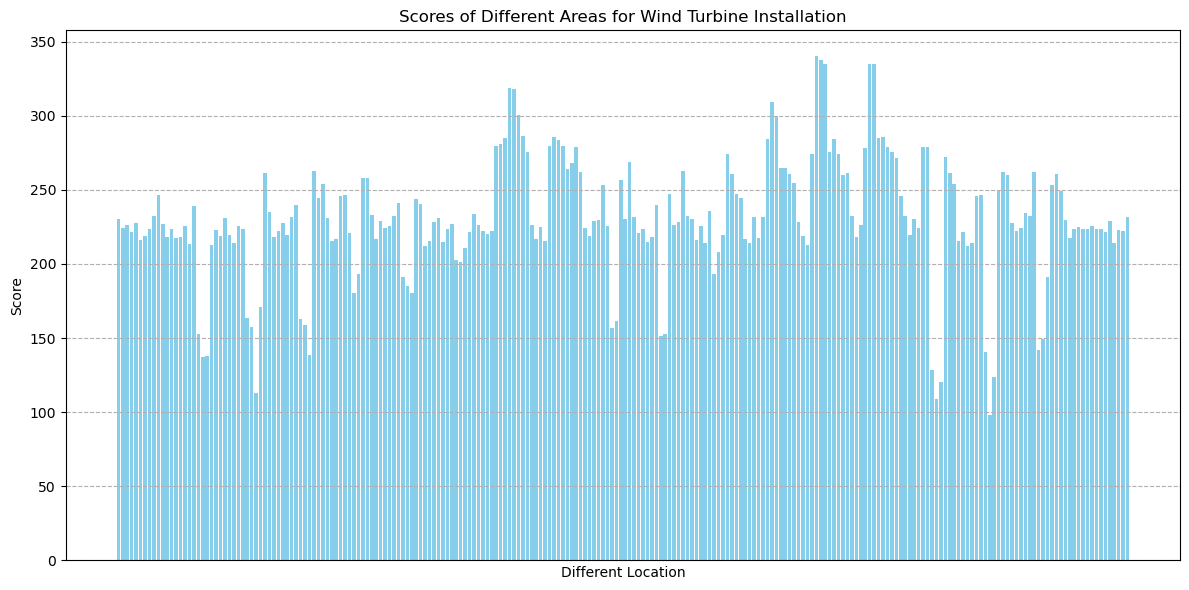

Bar chart saved as 'wind_farm_scores_bar_plot.png'


In [38]:
import os
from scipy.stats import skew
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

# Create a directory to save the plots (if it doesn't already exist)
save_directory = 'bar_graphs'
os.makedirs(save_directory, exist_ok=True)

# Store skewness, peak values, and other evaluation metrics
skewness_values = {}
peak_values = {}
mean_wind_speeds = {}
std_devs = {}
weibull_shapes = {}
weibull_scales = {}
plot_scores = {}

# Iterate over each grid area's data
for plot_name, df in plot_data.items():
    # Remove NaN values and take the absolute value
    df['Velocity [m/s]'] = df['Velocity [m/s]'].abs()
    wind_speeds = df['Velocity [m/s]'].dropna()

    # Filter out wind speeds above 25 m/s as turbines do not operate at such high speeds
    wind_speeds = wind_speeds[wind_speeds <= 25]

    # Check if there is valid data
    if len(wind_speeds) == 0:
        print(f"Skipping empty dataset or no valid data: {plot_name}")
        continue

    # Calculate basic statistical metrics
    mean_speed = wind_speeds.mean()
    std_dev = wind_speeds.std()
    skewness = skew(wind_speeds)

    # Store these metrics
    mean_wind_speeds[plot_name] = mean_speed
    std_devs[plot_name] = std_dev
    skewness_values[plot_name] = skewness

    # Fit the Weibull distribution
    shape, loc, scale = weibull_min.fit(wind_speeds, floc=0)
    weibull_shapes[plot_name] = shape
    weibull_scales[plot_name] = scale

    # Calculate Weibull PDF
    v_values = np.linspace(0, max(wind_speeds), 100)
    pdf_values = (shape / scale) * ((v_values / scale) ** (shape - 1)) * np.exp(-(v_values / scale) ** shape)
    peak_value = max(pdf_values)
    peak_values[plot_name] = peak_value

    # Determine the position of the PDF peak
    peak_position = v_values[np.argmax(pdf_values)]

    # Calculate the score based on evaluation criteria
    score = 0
    score += mean_speed * 10  # Weight for mean wind speed
    score += (6.5 - std_dev) * 5  # Weight for standard deviation (lower is better)
    score += shape * 8  # Weight for Weibull shape parameter
    score += scale * 7  # Weight for Weibull scale parameter
    score += (15 - abs(peak_position - 10)) * 3  # Weight for PDF peak position (optimal around 10 m/s)
    score += (0 - skewness) * 2  # Weight for skewness (close to 0 or negative is better)

    # Store the score
    plot_scores[plot_name] = score

    # Plot and save the Weibull PDF
    plt.plot(v_values, pdf_values, label=f'Plot {plot_name}')
    plt.title(f'Probability Density Function - Plot {plot_name}')
    plt.xlabel('Velocity [m/s]')
    plt.ylabel('Probability Density')
    plt.grid(True)
    
    # Save the plot
    plot_filename = os.path.join(save_directory, f'{plot_name}_pdf_plot.png')
    plt.savefig(plot_filename)
    plt.clf()  # Clear the plot to avoid overlap

# Find the area with the highest score
best_plot = max(plot_scores, key=plot_scores.get)
best_score = plot_scores[best_plot]

# Create a DataFrame to store all evaluation results
analysis_df = pd.DataFrame({
    'Mean Wind Speed': mean_wind_speeds,
    'Standard Deviation': std_devs,
    'Skewness': skewness_values,
    'Weibull Shape (k)': weibull_shapes,
    'Weibull Scale (λ)': weibull_scales,
    'Peak PDF Value': peak_values,
    'Score': plot_scores
})

# Print the best location
print(f"The most suitable area for establishing a wind power station: {best_plot}, Score: {best_score}")
print(analysis_df.loc[best_plot])

# Save the analysis results to a CSV file
analysis_df.to_csv('wind_farm_suitability_analysis.csv', index_label='Plot Name')
print("Analysis results saved to 'wind_farm_suitability_analysis.csv'")

# Plot a bar chart of the scores for each area
plt.figure(figsize=(12, 6))
plt.bar(plot_scores.keys(), plot_scores.values(), color='#87CEEB')
plt.title('Scores of Different Areas for Wind Turbine Installation')
plt.xlabel('Different Location')
plt.ylabel('Score')
plt.xticks([])  # Remove x-axis labels if they are too crowded
plt.grid(axis='y', linestyle='--')
plt.tight_layout()

# Save the bar chart as an image
bar_plot_filename = 'wind_farm_scores_bar_plot.png'
plt.savefig(bar_plot_filename)
plt.show()

print(f"Bar chart saved as '{bar_plot_filename}'")
